In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../..')))

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense,LSTM,Dropout

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

from src.modeling import results

In [2]:
# Load the data
data_clean = pd.read_csv("../../data/merged_data_ercot_2023.csv")
data_clean["Datetime"] = pd.to_datetime(data_clean["Datetime"])
data_clean.set_index('Datetime', inplace=True)

In [3]:
train_size = int(len(data_clean) * 0.8)
respondent = "ERCO"

In [ ]:
# Split the data 
X_lstm = data_clean
y_lstm = data_clean['Energy_MW']


scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()


X_train_lstm, X_test_lstm = X_lstm.iloc[:train_size], X_lstm.iloc[train_size:]
y_train_lstm, y_test_lstm = y_lstm.iloc[:train_size], y_lstm.iloc[train_size:]

X_train_scaled = scaler_X.fit_transform(X_train_lstm)
X_test_scaled = scaler_X.transform(X_test_lstm)
y_train_scaled = scaler_y.fit_transform(y_train_lstm.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_lstm.values.reshape(-1, 1))

In [ ]:
# Model architecture

batch_size = 1
length = 24

train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=length, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=length, batch_size=batch_size)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, X_train_lstm.shape[1])))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Train and save the model
model.fit(train_generator, epochs=10, verbose=1)
model.save(f"../../models/energy_forecast_model_{respondent.lower()}_lstm.h5")
print(f"LSTM model saved as 'energy_forecast_model_{respondent.lower()}_lstm.h5'")


In [ ]:
#Load the model and evaluate
model = load_model(f"../../models/energy_forecast_model_{respondent.lower()}_lstm.h5", custom_objects={'mse': MeanSquaredError}, compile=False)
model.compile(optimizer='adam', loss=MeanSquaredError())
print("Model loaded successfully")

pred_test_lstm= model.predict(test_generator)
pred_train_lstm = model.predict(train_generator)

pred_test_lstm_rescaled = scaler_y.inverse_transform(pred_test_lstm)
pred_train_lstm_rescaled = scaler_y.inverse_transform(pred_train_lstm)

Model loaded successfully


RMSE: 714.31 MW


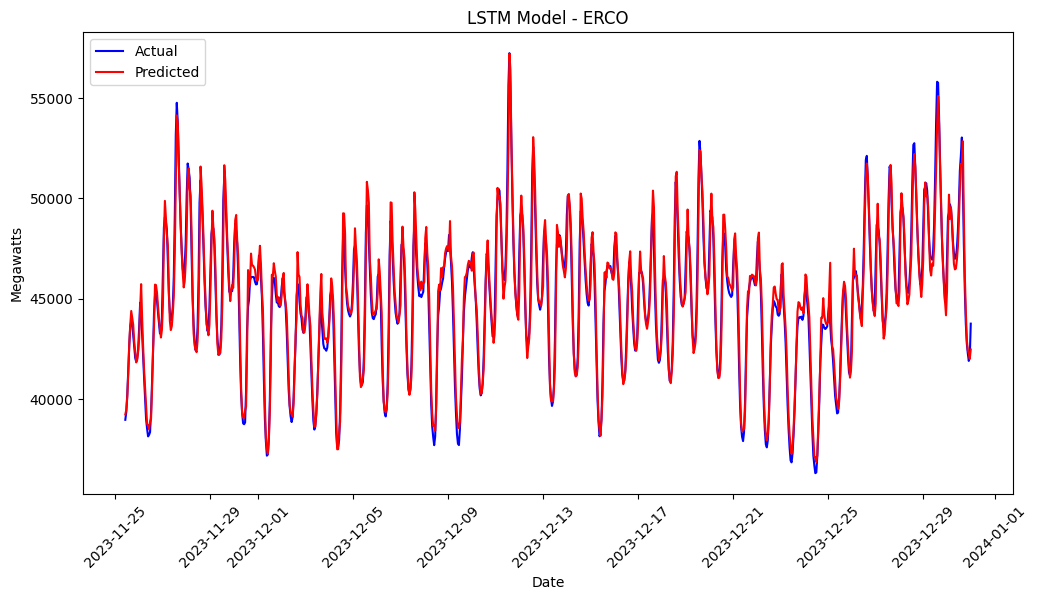

In [10]:
results(y_test_lstm[length:], pred_test_lstm_rescaled, f"LSTM Model - {respondent}")

RMSE: 880.19 MW


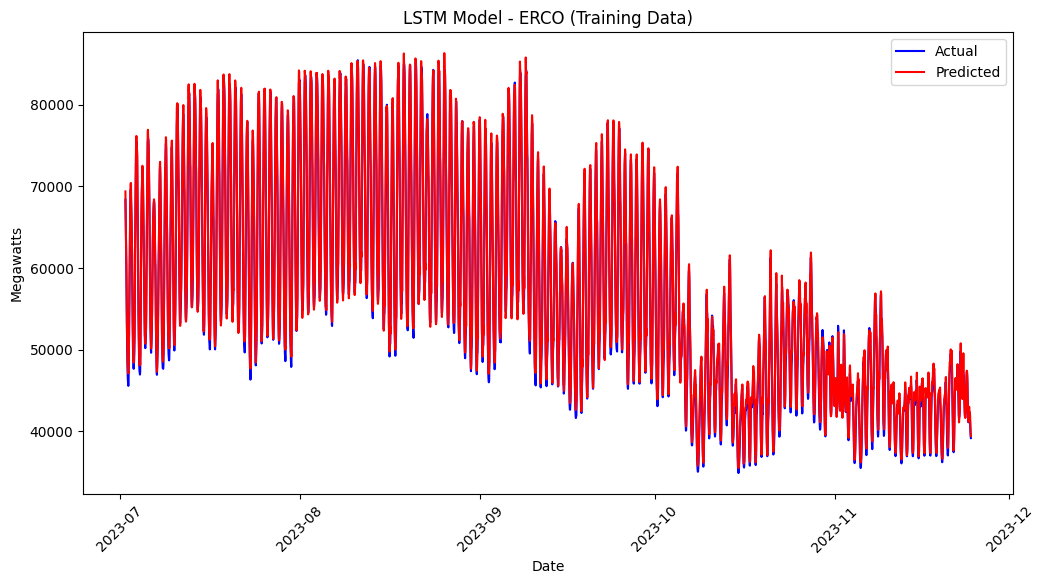

In [11]:
results(y_train_lstm[length:], pred_train_lstm_rescaled, f"LSTM Model - {respondent} (Training Data)")